# **CUSTOM ENCODER-DECODER MODEL**

In [ ]:
# Install required libraries
!pip install datasets transformers nltk torch

# Import libraries for NLP, dataset handling, and model training
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer
from datasets import load_dataset
from nltk.translate.gleu_score import sentence_gleu
from tqdm import tqdm
import nltk

# Download NLTK tokenizer data
nltk.download("punkt")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load the JFLEG dataset
dataset = load_dataset("jhu-clsp/jfleg")

# Split the validation set into training and validation subsets (80% train, 20% validation)
train_test_split = dataset['validation'].train_test_split(test_size=0.2)
dataset = {
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
    'test': dataset['test']
}

# Load the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.94k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/141k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/748 [00:00<?, ? examples/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def preprocess_function(examples):
    # Add the prefix "fix: " to each input sentence
    inputs = ["fix: " + sentence for sentence in examples["sentence"]]

    # Use the first correction from the corrections list as the target (or an empty string if no corrections)
    targets = [correction[0] if correction else "" for correction in examples["corrections"]]

    # Tokenize inputs with padding and truncation
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    # Tokenize targets and assign them as labels
    model_inputs["labels"] = tokenizer(targets, max_length=128, truncation=True, padding="max_length")["input_ids"]

    return model_inputs


In [ ]:
tokenized_datasets = {
    split: dataset[split].map(preprocess_function, batched=True)
    for split in dataset
}

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [ ]:
# Custom dataset class for grammar correction
class GrammarDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=128):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Tokenize input and target texts
        input_tokens = self.tokenizer(
            self.inputs[idx], max_length=self.max_length, truncation=True, padding="max_length", return_tensors="pt"
        )
        target_tokens = self.tokenizer(
            self.targets[idx], max_length=self.max_length, truncation=True, padding="max_length", return_tensors="pt"
        )
        return {
            "input_ids": input_tokens["input_ids"].squeeze(),
            "attention_mask": input_tokens["attention_mask"].squeeze(),
            "labels": target_tokens["input_ids"].squeeze(),
        }

# Encoder for the Seq2Seq model
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Embed the input sequence and pass it through the LSTM
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

# Decoder for the Seq2Seq model
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, cell):
        # Process one token at a time in the decoder
        trg = trg.unsqueeze(1)
        embedded = self.dropout(self.embedding(trg))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

# Seq2Seq model combining the encoder and decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # Initialize variables for outputs
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode the source sequence
        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # Start with the first token of the target sequence

        # Decode each token
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)  # Get the predicted token
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


In [ ]:
# Prepare the training and validation datasets
train_data = GrammarDataset(
    inputs=tokenized_datasets["train"]["sentence"],
    targets=[correction[0] for correction in tokenized_datasets["train"]["corrections"]],
    tokenizer=tokenizer
)
val_data = GrammarDataset(
    inputs=tokenized_datasets["validation"]["sentence"],
    targets=[correction[0] for correction in tokenized_datasets["validation"]["corrections"]],
    tokenizer=tokenizer
)

# Use the test dataset directly
test_data = tokenized_datasets["test"]

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# Define model hyperparameters
INPUT_DIM = tokenizer.vocab_size  # Vocabulary size for the input
OUTPUT_DIM = tokenizer.vocab_size  # Vocabulary size for the output
EMBED_DIM = 256  # Embedding dimension size
HIDDEN_DIM = 512  # Hidden state size in the RNN
NUM_LAYERS = 2  # Number of layers in the RNN
DROPOUT = 0.5  # Dropout rate for regularization
LEARNING_RATE = 1e-3  # Learning rate for the optimizer
N_EPOCHS = 5  # Number of training epochs

# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
encoder = Encoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
seq2seq = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(seq2seq.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    for batch in tqdm(loader):  # Iterate through batches with a progress bar
        src = batch["input_ids"].to(DEVICE)  # Move input data to the device
        trg = batch["labels"].to(DEVICE)  # Move target data to the device

        optimizer.zero_grad()  # Clear gradients from the previous step

        output = model(src, trg)  # Forward pass through the model
        output_dim = output.shape[-1]

        # Reshape outputs and targets for loss calculation
        output = output[:, 1:].reshape(-1, output_dim)  # Ignore the start token in outputs
        trg = trg[:, 1:].reshape(-1)  # Ignore the start token in targets

        loss = criterion(output, trg)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        epoch_loss += loss.item()  # Accumulate the batch loss

    return epoch_loss / len(loader)  # Return average loss for the epoch


In [ ]:
def evaluate_epoch(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    epoch_loss = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in loader:
            src = batch["input_ids"].to(DEVICE)  # Move input data to the device
            trg = batch["labels"].to(DEVICE)  # Move target data to the device

            # Forward pass with teacher forcing disabled
            output = model(src, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]

            # Reshape outputs and targets for loss calculation
            output = output[:, 1:].reshape(-1, output_dim)  # Ignore the start token in outputs
            trg = trg[:, 1:].reshape(-1)  # Ignore the start token in targets

            loss = criterion(output, trg)  # Calculate the loss
            epoch_loss += loss.item()  # Accumulate the batch loss

    return epoch_loss / len(loader)  # Return average loss for the epoch

# Training loop
for epoch in range(N_EPOCHS):
    train_loss = train_epoch(seq2seq, train_loader, optimizer, criterion)  # Train for one epoch
    val_loss = evaluate_epoch(seq2seq, val_loader, criterion)  # Evaluate on validation data
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch 1/5 - Train Loss: 6.9637, Val Loss: 6.0342


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch 2/5 - Train Loss: 5.7228, Val Loss: 6.0167


100%|██████████| 38/38 [00:36<00:00,  1.04it/s]


Epoch 3/5 - Train Loss: 5.6383, Val Loss: 6.0319


100%|██████████| 38/38 [00:36<00:00,  1.04it/s]


Epoch 4/5 - Train Loss: 5.6123, Val Loss: 6.0416


100%|██████████| 38/38 [00:36<00:00,  1.04it/s]


Epoch 5/5 - Train Loss: 5.5626, Val Loss: 6.0419


In [ ]:
# Function to evaluate the GLEU score of corrected sentences
def evaluate_gleu(corrected_sentences, test_data):
    gleu_scores = []

    for corrected_sentence, references in zip(corrected_sentences, test_data["corrections"]):
        # Tokenize the predicted and reference sentences
        prediction_tokens = corrected_sentence.split()
        reference_tokens = [ref.split() for ref in references]

        # Calculate GLEU score for the current sentence
        gleu_score = sentence_gleu(reference_tokens, prediction_tokens)
        gleu_scores.append(gleu_score)

    # Calculate the average GLEU score across all sentences
    avg_gleu_score = sum(gleu_scores) / len(gleu_scores)
    print(f"\nAverage GLEU Score: {avg_gleu_score:.4f}")
    return avg_gleu_score

# Function to test the model on unseen test data
def test_model(model, test_data):
    model.eval()  # Set the model to evaluation mode
    corrected_sentences = []

    with torch.no_grad():  # Disable gradient computation
        for sentence in test_data["sentence"]:
            # Tokenize the input sentence
            input_tokens = tokenizer(
                "fix: " + sentence, max_length=128, truncation=True, padding="max_length", return_tensors="pt"
            ).to(DEVICE)
            src = input_tokens["input_ids"]

            # Encode the input sentence
            hidden, cell = model.encoder(src)

            # Start generating output with the PAD token
            trg_token = torch.tensor([tokenizer.pad_token_id]).to(DEVICE)
            generated_sentence = []

            # Decode up to 128 tokens or until EOS token is encountered
            for _ in range(128):
                output, hidden, cell = model.decoder(trg_token, hidden, cell)
                trg_token = output.argmax(1)  # Get the token with the highest probability
                if trg_token.item() == tokenizer.eos_token_id:  # Stop if EOS token is generated
                    break
                generated_sentence.append(trg_token.item())

            # Decode the generated tokens into a sentence
            corrected_sentence = tokenizer.decode(generated_sentence, skip_special_tokens=True)
            corrected_sentences.append(corrected_sentence)

    return corrected_sentences

# Generate corrected sentences and evaluate their GLEU score
corrected_sentences_seq2seq = test_model(seq2seq, test_data)
gleu_score_seq2seq = evaluate_gleu(corrected_sentences_seq2seq, test_data)



Average GLEU Score: 0.0330


In [ ]:
# We are not satisfied with the results when we tried to implement our own encoder and decoder, So now we tried using the t5-base model and then fine tuned it so that we get a better GLEU score.

T5 **Model**

In [ ]:
!pip install openai==0.28
!pip install transformers datasets nltk

In [ ]:
# Import necessary libraries
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import torch
import nltk
from nltk.translate.gleu_score import sentence_gleu
import openai
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords


nltk.download("punkt")

openai.api_key = 'Your_api_key_here'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dataset = load_dataset("jhu-clsp/jfleg")

train_test_split = dataset['validation'].train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
    'test': dataset['test']
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

dataset_size = {split: len(dataset[split]) for split in dataset.keys()}
print("Dataset Size:", dataset_size)

dataset_df = dataset['train'].to_pandas()


Dataset Size: {'train': 604, 'validation': 151, 'test': 748}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print("Dataset Head:")
print(dataset_df.head())

Dataset Head:
                                            sentence  \
0  Then , how about if the talkkative explains th...   
1  becaese when we learn about some subjects we s...   
2  In my opinion , if they start one subject , ne...   
3  As well as the knowledge plays also important ...   
4        by this you can learn gain the knowlegde .    

                                         corrections  
0  [Then , what if the speaker explains the proje...  
1  [My first reason is that when we learn about s...  
2  [In my opinion , if they start one subject , n...  
3  [Knowledge plays an important role in the life...  
4  [With this you can learn and gain knowledge . ...  


In [ ]:
print("Dataset Description:")
print(dataset_df.describe())

Dataset Description:
                                                 sentence  \
count                                                 604   
unique                                                604   
top     Then , how about if the talkkative explains th...   
freq                                                    1   

                                              corrections  
count                                                 604  
unique                                                604  
top     [Then , what if the speaker explains the proje...  
freq                                                    1  


In [ ]:
all_words = [word for sentence in dataset_df['sentence'] for word in sentence.split()]
stopword_count = sum(1 for word in all_words if word.lower() in stop_words)
non_stopword_count = len(all_words) - stopword_count

print("Stopword Count:", stopword_count)
print("Non-Stopword Count:", non_stopword_count)

Stopword Count: 5137
Non-Stopword Count: 6108


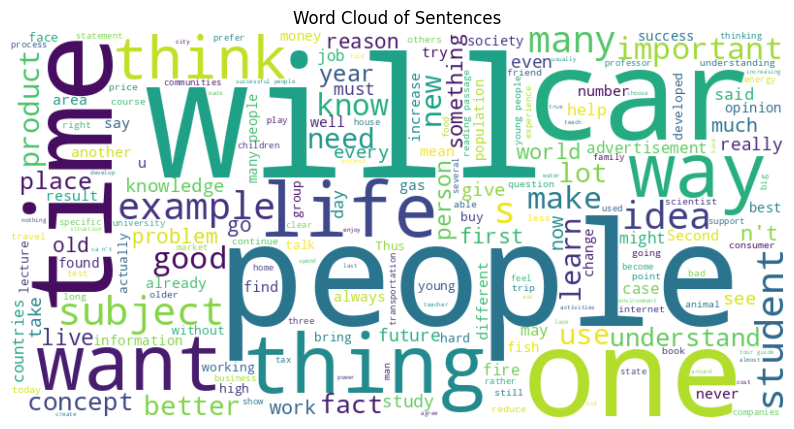

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Sentences")
plt.show()

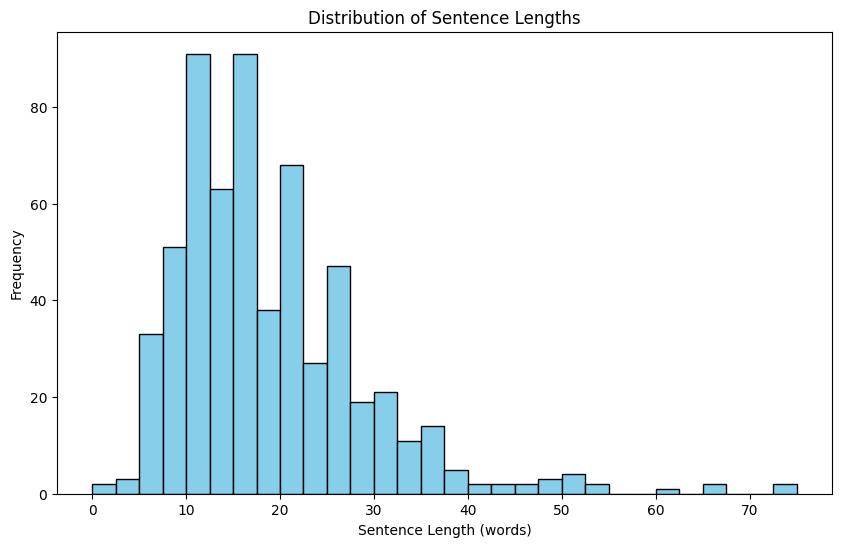

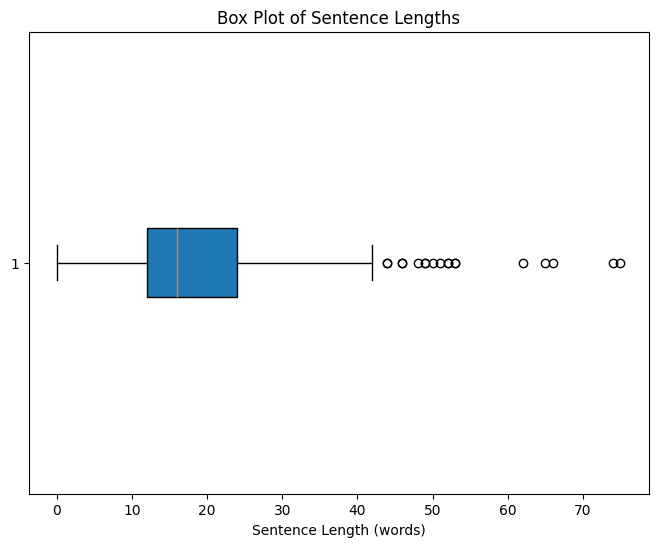

In [ ]:
# Calculate the length of each sentence in words
dataset_df['sentence_length'] = dataset_df['sentence'].apply(lambda x: len(x.split()))

# Plot the histogram to visualize the distribution of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(dataset_df['sentence_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.show()

# Plot a box plot to observe the spread and outliers of sentence lengths
plt.figure(figsize=(8, 6))
plt.boxplot(dataset_df['sentence_length'], vert=False, patch_artist=True)
plt.title("Box Plot of Sentence Lengths")
plt.xlabel("Sentence Length (words)")
plt.show()


In [ ]:
model_name = "t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_name).to("cuda")
tokenizer = T5Tokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = ["fix: " + sentence for sentence in examples["sentence"]]
    targets = [correction[0] if correction else "" for correction in examples["corrections"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = tokenizer(text_target=targets, max_length=128, truncation=True, padding="max_length")["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/604 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./t5_finetuned_jfleg",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,0.172567
2,No log,0.117781
3,No log,0.112433
4,No log,0.111366
5,No log,0.110306
6,No log,0.110003
7,0.443800,0.111135
8,0.443800,0.111510
9,0.443800,0.112523
10,0.443800,0.112854


TrainOutput(global_step=760, training_loss=0.3178934850190815, metrics={'train_runtime': 460.8234, 'train_samples_per_second': 13.107, 'train_steps_per_second': 1.649, 'total_flos': 919526414745600.0, 'train_loss': 0.3178934850190815, 'epoch': 10.0})

In [ ]:

# Function for grammar correction
def correct_grammar(test_data):
    corrected_sentences = []
    for sentence in test_data["sentence"]:
        input_text = f"fix: {sentence}"
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to("cuda")
        outputs = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
        corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Keeping original sentence if corrected output is empty
        corrected_sentence = corrected_sentence if corrected_sentence.strip() else sentence
        corrected_sentences.append(corrected_sentence)

        print(f"Original: {sentence}")
        print(f"Corrected: {corrected_sentence}")
        print("="*40)

    return corrected_sentences

In [ ]:
# Function for grammar correction
def correct_grammar(test_data):
    corrected_sentences = []
    total_sentences = len(test_data["sentence"])

    for idx, sentence in enumerate(test_data["sentence"]):
        input_text = f"fix: {sentence}"
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to("cuda")
        outputs = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
        corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Keeping original sentence if corrected output is empty
        corrected_sentence = corrected_sentence if corrected_sentence.strip() else sentence
        corrected_sentences.append(corrected_sentence)

        # Print only for the last 30 sentences
        if idx >= total_sentences - 30:
            print(f"Original: {sentence}")
            print(f"Corrected: {corrected_sentence}")
            print("="*40)

    return corrected_sentences


In [ ]:
# Function to evaluate GLEU score
def evaluate_gleu(corrected_sentences, test_data):
    gleu_scores = []
    for corrected_sentence, references in zip(corrected_sentences, test_data["corrections"]):
        prediction_tokens = corrected_sentence.split()
        reference_tokens = [ref.split() for ref in references]
        gleu_score = sentence_gleu(reference_tokens, prediction_tokens)
        gleu_scores.append(gleu_score)

    avg_gleu_score = sum(gleu_scores) / len(gleu_scores)
    print(f"\nAverage GLEU Score: {avg_gleu_score:.4f}")
    return avg_gleu_score

In [ ]:
# Function to provide feedback using OpenAI API
def provide_feedback(sentences):
    for sentence in sentences[-30:]:
        prompt = f"The sentence is: '{sentence}'\n" \
                 f"Please provide detailed feedback on the grammatical correctness of this sentence and suggest improvements if necessary."
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a grammar expert."},
                {"role": "user", "content": prompt}
            ]
        )
        feedback = response['choices'][0]['message']['content']
        print(f"Feedback for: '{sentence}'\n{feedback}")
        print("="*80)


sentences = [...]

In [ ]:
corrected_sentences = correct_grammar(tokenized_datasets["test"])

# Evaluating model based on GLEU score on the test set
evaluate_gleu(corrected_sentences, tokenized_datasets["test"])

provide_feedback(corrected_sentences)

Original: Thus , after you return to the city , you may became brothers .
Corrected: Thus , after you return to the city , you may become brothers .
Original: Its not incorrect to say that the world is losing some great support system to which the young people can greatly contribute .
Corrected: It is not incorrect to say that the world is losing some great support system to which the young people can greatly contribute .
Original: Becaus we need food .
Corrected: Becaus we need food .
Original: When there is need to do something , young peolpe do not think .
Corrected: When there is need to do something , young people do not think .
Original: He will be matured enough to take wise decisions in expanding his business and trying out new things .
Corrected: He will be mature enough to take wise decisions in expanding his business and trying out new things .
Original: The ecological balance should be for the entire area .
Corrected: The ecological balance should be for the entire area .
O

# **ROBUSTNESS EVALUATION**

In [ ]:
import random
import string

def introduce_spelling_errors(sentence, error_rate=0.1):
    """
    Introduces spelling errors into a given sentence by either swapping
    two characters or deleting one character in a word.

    Args:
    - sentence (str): The input sentence.
    - error_rate (float): Probability of introducing an error in each word (default: 0.1).

    Returns:
    - str: The sentence with spelling errors.
    """
    words = sentence.split()  # Split the sentence into words
    perturbed_words = []

    for word in words:
        if random.random() < error_rate:  # Introduce error based on error_rate
            # Randomly choose the type of error: swap or delete
            perturb_type = random.choice(["swap", "delete"])

            if perturb_type == "swap" and len(word) > 1:
                # Swap two random characters in the word
                chars = list(word)
                idx1, idx2 = random.sample(range(len(chars)), 2)  # Pick two random indices
                chars[idx1], chars[idx2] = chars[idx2], chars[idx1]  # Swap characters
                word = "".join(chars)

            elif perturb_type == "delete" and len(word) > 1:
                # Delete a random character from the word
                chars = list(word)
                del chars[random.randrange(len(chars))]  # Remove a random character
                word = "".join(chars)

        perturbed_words.append(word)  # Add the (possibly perturbed) word to the list

    return " ".join(perturbed_words)  # Reconstruct the sentence


In [ ]:
def introduce_case_noise(sentence, error_rate=0.1):
    """
    Introduces case-based noise into a sentence by randomly changing
    the case of words based on a specified error rate.

    Args:
    - sentence (str): The input sentence.
    - error_rate (float): Probability of changing the case of each word (default: 0.1).

    Returns:
    - str: The sentence with case-based noise.
    """
    words = sentence.split()  # Split the sentence into words
    perturbed_words = []

    for word in words:
        if random.random() < error_rate:  # Apply case noise based on error_rate
            # Randomly change the case of the word
            case_type = random.choice(["upper", "lower", "title"])
            if case_type == "upper":
                word = word.upper()  # Convert to uppercase
            elif case_type == "lower":
                word = word.lower()  # Convert to lowercase
            elif case_type == "title":
                word = word.title()  # Capitalize the first letter
        perturbed_words.append(word)  # Add the (possibly perturbed) word to the list

    return " ".join(perturbed_words)  # Reconstruct the sentence


In [ ]:
def introduce_punctuation_noise(sentence, error_rate=0.1):
    """
    Introduces punctuation noise into a sentence by randomly inserting
    a punctuation mark at a random position based on a specified error rate.

    Args:
    - sentence (str): The input sentence.
    - error_rate (float): Probability of adding punctuation noise (default: 0.1).

    Returns:
    - str: The sentence with punctuation noise.
    """
    if random.random() < error_rate:  # Apply punctuation noise based on error_rate
        rand_punc = random.choice(string.punctuation)  # Randomly select a punctuation mark
        pos = random.randrange(len(sentence))  # Choose a random position in the sentence
        # Insert the punctuation at the chosen position
        sentence = sentence[:pos] + rand_punc + sentence[pos:]

    return sentence


In [ ]:
def shuffle_word_order(sentence, error_rate=0.1):
    """Shuffle the order of words in a sentence."""
    words = sentence.split()
    if random.random() < error_rate and len(words) > 1:
        random.shuffle(words)
    return " ".join(words)

In [ ]:
def remove_random_words(sentence, error_rate=0.1):
    """Remove random words from the sentence."""
    words = sentence.split()
    if random.random() < error_rate:
        num_to_remove = max(1, int(len(words) * error_rate))
        for _ in range(num_to_remove):
            if words:
                del words[random.randrange(len(words))]
    return " ".join(words)

In [ ]:
# Generate Perturbed Dataset
def create_perturbed_dataset(original_dataset, perturb_functions, error_rate=0.1):
    """
    Apply a list of perturbation functions to an input dataset.
    Args:
        original_dataset: Dataset with "sentence" as input column.
        perturb_functions: List of perturbation functions.
        error_rate: Probability of applying each perturbation.
    Returns:
        A dictionary with perturbed sentences and original corrections.
    """
    perturbed_data = {"sentence": [], "corrections": original_dataset["corrections"]}
    for sentence in original_dataset["sentence"]:
        for perturb_func in perturb_functions:
            sentence = perturb_func(sentence, error_rate)
        perturbed_data["sentence"].append(sentence)
    return perturbed_data

In [ ]:
perturb_functions = [
    introduce_spelling_errors,
    introduce_punctuation_noise,
    introduce_case_noise,
    shuffle_word_order,
    remove_random_words,
]

perturbed_test_data = create_perturbed_dataset(
    original_dataset=tokenized_datasets["test"],
    perturb_functions=perturb_functions,
    error_rate=0.1
)

# Evaluate on Perturbed Dataset
corrected_perturbed_sentences = correct_grammar(perturbed_test_data)
evaluate_gleu(corrected_perturbed_sentences, perturbed_test_data)
provide_feedback(corrected_perturbed_sentences)

Original: Thus , after you return to te city , YOU may became broters .
Corrected: Thus , after you return to the city , YOU may become broters .
Original: Its not incorrect to say that the world is losing some great support system to which the young people can greatly contribute .
Corrected: It is not incorrect to say that the world is losing some great support system to which the young people can greatly contribute .
Original: Becus We need food .
Corrected: Becus We need food .
Original: When there si need to do soething , young Peolpe do Not think .
Corrected: When there is need to do something , young people do not think .
Original: e WILL be matured enough ot take wise decisions in expanding his business nad Trying out wen thins .
Corrected: e WILL be mature enough to take wise decisions in expanding his business , and trying out new things .
Original: The ecological balance should be or The entire area .
Corrected: The ecological balance should be or the entire area .
Original: 